## Simple one-spin pulse acquire simulation in Liouville space, but without relaxation
Note: everything in SI units for clarity, frequencies in linear frequencies!

### 1) Imports

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

### 2) Build spin operator matrices

In [2]:
Ix = 1/2*np.array([[0,1],[1,0]])
Iy = 1/2*np.array([[0,-1j],[1j,0]])
Iz = 1/2*np.array([[1,0],[0,-1]])
Ip = Ix+1j*Iy
Im = Ix-1j*Iy
E = np.eye(2)

### 3) Set Hamiltonian parameters and build the matrix

In [3]:
offset = 4e3   #4 kHz offset
H0 = offset*Iz

k_z = 5e2
k_xy = 1e2

T2 = 1/(k_xy+k_z)
T1 = 1/(2*k_xy)

### 4) Set simulation parameters

In [4]:
rho0 = Iz  #Starting density operator
pulseOp = Iy #Pulse operator
detOp = Ix + 1j*Iy #detection operator

rho_eq=Iz #Equilibrium operator

dt = 10e-6 #Sampling time step (dwell time)
nPoints = 1024  #Length of acquisition
t = np.arange(1024)*dt #Time vector

sig = np.zeros(nPoints,dtype=complex) #Pre-allocation of signal vector

### 5) Actual simulation

In [5]:
#Convert everything into Liouville space
H0_L = np.kron(H0,E)-np.kron(E,H0.T)
rho0_L = rho0.T.flatten()  #Creates a vector out of the rho0 matrix
pulseOp_L = np.kron(pulseOp,E)-np.kron(E,pulseOp.T)
detOp_L = detOp.conj().T.flatten()
rho_eq_L = rho_eq.T.flatten()

Ix_doub_comm = (np.kron(Ix,E)-np.kron(E,Ix.T))@(np.kron(Ix,E)-np.kron(E,Ix.T))
Iy_doub_comm = (np.kron(Iy,E)-np.kron(E,Iy.T))@(np.kron(Iy,E)-np.kron(E,Iy.T))
Iz_doub_comm = (np.kron(Iz,E)-np.kron(E,Iz.T))@(np.kron(Iz,E)-np.kron(E,Iz.T))

#Generate relaxation superoperator
R = k_z*Iz_doub_comm + k_xy*(Ix_doub_comm+Iy_doub_comm)

#start sim
rho_L = rho0_L

# apply pulse propagator to initial density operator
Upulse_L = expm(-1j*np.pi/2*pulseOp_L)
rho_L = Upulse_L@rho_L

# build propagator of free evolution and acquire
U0_L = expm(-1j*2*np.pi*H0_L*dt-R*dt)

for k in range(nPoints):
    sig[k] = detOp_L@rho_L
    rho_L = U0_L@rho_L

### 6) Plot real and imaginary part, and relaxation on top

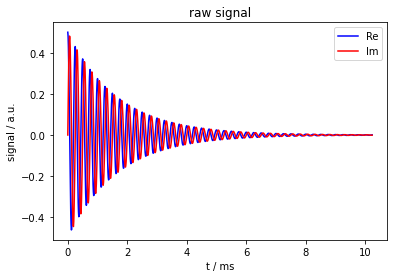

In [6]:
ax=plt.subplots()[1]
ax.plot(t*1e3,sig.real,color='blue')
ax.plot(t*1e3,sig.imag,color='red')
ax.set_title('raw signal')
ax.set_xlabel('t / ms')
ax.set_ylabel('signal / a.u.')
ax.legend(('Re','Im'))

### 7) Apodize, i.e. multiply with window function

In [7]:
twin = np.inf #Apodization parameter
win = np.exp(-t/twin)

#Apply window to signal
sig_apo = sig*win

# ax=plt.subplots()[1]
# ax.plot(t*1e3,sig_apo.real,color='red')
# ax.plot(t*1e3,sig_apo.imag,color='blue')
# ax.set_title('Apodized signal')
# ax.set_xlabel('t / ms')
# ax.set_ylabel('signal / a.u.')
# ax.legend(('Re','Im'))

### 8) Fourier transform with zero-filling, construction of the frequency vector

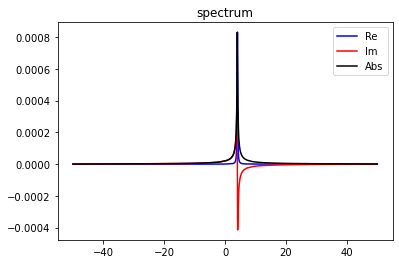

In [8]:
sig_apo[0]/=2 #Divide first point by 2 to get correct baseline
spec=np.fft.fftshift(np.fft.fft(sig_apo,2*nPoints))*dt

#Frequency vector
N=spec.size
nyqFreq = 1/(2*dt)
unitAxis=2/N*(np.arange(N)-N//2)
freq = nyqFreq*unitAxis

ax=plt.subplots()[1]
ax.plot(freq/1e3,spec.real,color='blue')
ax.plot(freq/1e3,spec.imag,color='red')
ax.plot(freq/1e3,np.abs(spec),color='black')
ax.set_title('spectrum')
ax.legend(('Re','Im','Abs'))

### 9) Basis transformation

In [25]:
#Basis transformation to operator basis
B=np.zeros([E.size,4],dtype=complex)
B[:,0]=E.T.flatten()
B[:,1]=Iz.T.flatten()
B[:,2]=Ix.T.flatten()
B[:,3]=Iy.T.flatten()

#Normalize eigenvectors
for i in range(B.shape[1]):
    B[:,i]=B[:,i]/np.sqrt(B[:,i]@B[:,i].conj())

#Check that B is unitary
print("B*B':")
print(B@B.conj().T)

#Convert to Operator basis
H0_L_B = B.conj().T@H0_L@B
rho0_L_B = B.conj().T@rho0_L
pulseOp_L_B = B.conj().T@pulseOp_L@B
detOp_L_B = B.conj().T@detOp_L
rho_eq_L_B = B.conj().T@rho_eq_L
R_B=B.conj()@R@B

B*B':
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
